# Wind Farm Test
In this file, one can test certain wind farm layouts and configurations. Some basic functions are demonstrated. With the resulting turbine power outputs and flowfields, one can make their own comparisons between farms.

### Import libraries
Here, the libraries used in this file are imported.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import time
import os
from IPython.display import display, clear_output
from scipy import optimize
from itertools import product

# Import custom libraries
import functions as func
import visualization as viz

# Import models
from floris.tools import FlorisInterface as floris

### Model Framework
Here, several classes are made. The main class `WakeModeling` creates an instance from where all options of the wake modeling can be handeled. Furthermore, different classes are made for every available model. Currently, these exist out of the Cumulative Curl Misalignment (`CCM`) model, which can be used for optimization purposes, and Large Eddy Simulation (`LES`), which is currently used as reference data.

In [123]:
# TODO: add all this to a Python file, if everything works fine and entire framework is finished
# For now this is more practical, since notebook doesn't have to restart after every change

# Add names of newly added models in this list
model_names = [
    'CCM',
]

ref_models = [
    'LES',
]

# Create classes for models
class LES:
    '''
    This class provides tools for handling data obtained with Large Eddy Simulations.
    The output of functions in this class is standardized, so data structures are
    equal between different datasources.
    '''

    def __init__(
        self,
    ):
        pass


    # Get flowfield dataframe
    def get_df_flowfield(
        case_name: str = None,
        location: str = '../LES/',
    ):
        '''
        Get the flowfield dataframe of a LES case.

        Args:
            case_name (str): the name of the case
            location (str): the path to the LES data

        Returns:
            DataFrame: dataframe containing the flowfield data
        '''
        df_flowfield = pd.read_csv(location + case_name + '/' + case_name + '.csv')

        return df_flowfield
    

    def get_gridpoints(
        df_flowfield,    
    ):
        '''
        Get the gridpoints of the LES data

        Args:
            df_flowfield (DataFrame): dataframe containing LES flowfield

        Returns:
            tuple: respectivily the ndarrays of X, Y and Z gridpoints
        '''
        X = np.array(sorted(df_flowfield['Points:0'].unique()))
        Y = np.array(sorted(df_flowfield['Points:1'].unique()))
        Z = np.array(sorted(df_flowfield['Points:2'].unique()))
        
        return X, Y, Z
    

    def get_ABL_params(
        self,
        case_name: str = '1TURB_wd270_ws10_1x_y0_t5',
        location: str = '../LES/',
        z_ref_guess: float = 100,
        U_ref_guess: float = 10,
        alpha_guess: float = 0.12,
    ):  
        '''
        Get the fitted parameters that describe the Atmospheric Boundary
        Layer (ABL) as close as possible below 600m.

        Args:
            case_name (str): the name of the case
            location (str): the path to the LES data
            z_ref_guess (float): initial guess for reference height
            U_ref_guess (float): initial guess for reference velocity
            alpha_guess (float): initial guess for alpha

        Returns:
            dict: containing two arrays with fitted values describing the ABL
        '''
        # Get flowfield
        df_flowfield = self.get_df_flowfield(
            case_name,
            location,
        )

        # Get LES grid points
        X, Y, Z = self.get_gridpoints(df_flowfield)

        # Get U and V profiles of LES simulation at inflow boundary (X = 0)
        U_LES = df_flowfield[df_flowfield['Points:0'] == 0].groupby(['Points:2'])['UAvg:0'].mean().to_numpy()
        V_LES =  df_flowfield[df_flowfield['Points:0'] == 0].groupby(['Points:2'])['UAvg:1'].mean().to_numpy()

        # Get id of points at Z = 600, right before inversion layer starts
        idz, z_value = func.find_nearest(Z, 600)

        # Get U and V profiles from just above Z = 0 to Z = 600, before inversion layer
        cut_start = 2
        Z_cut = Z[cut_start:idz+1]
        U_LES_cut = U_LES[cut_start:idz+1]
        V_LES_cut = V_LES[cut_start:idz+1]

        # Fit streamwise velocity profile parameters
        U_params, _ = sc.optimize.curve_fit(
            func.U_profile, 
            Z_cut, 
            U_LES_cut, 
            p0=[z_ref_guess, U_ref_guess, alpha_guess], 
            bounds=([1, 1, 1e-6], [1e6, 1e6, 1])
        )

        # Fit spanwise velocity profile parameters
        V_params, _ = sc.optimize.curve_fit(
            func.V_profile, 
            Z_cut, 
            V_LES_cut
        )

        return {
            'U_params': U_params,
            'V_params': V_params,
        }


class CCM:
    '''
    This class provides tools for getting and handling data of the Cumulative Curl
    Misalignment (CCM) model, as implemented in FLORIS.
    The output of functions in this class is standardized, so data structures are
    equal between different datasources.

    Args:
        model_params (dict): dictionary containing the model parameters
        input_file (str): path to the initial case file used for FLORIS (CCM)
    '''

    def __init__(
        self,
        model_params: dict = None,
        input_file: str = 'model_files/CCM/case_initial.yaml',
    ):
        self.input_file = input_file
        self.model_params = model_params

        self.farm = floris(self.input_file)
        

    def get_farm(self):
        '''
        Get farm object
        '''
        return self.farm
    

    def set_model_params(
        self,
        model_params: dict,
    ):
        '''
        Set model parameters to the CCM model.

        Args:
            model_params (dict): dictionary containing the model parameters
        '''
        # Loop over all model parameters
        for key in model_params.keys():
            found = False

            # Check if in 'gaussm' and if so, apply change
            if key in self.farm.floris.wake.wake_deflection_parameters['gaussm'].keys():
                self.farm.floris.wake.wake_deflection_parameters['gaussm'][key] = model_params[key]
                found = True

            # Check if in 'ccm' and if so, apply change
            if key in self.farm.floris.wake.wake_velocity_parameters['ccm'].keys():
                self.farm.floris.wake.wake_velocity_parameters['ccm'][key] = model_params[key]
                found = True
            
            # Print message if parameter is not found
            if not found:
                print(f'Key named "{key}" not found in either model')
    

    def reinitialize_farm(
        self,
        farm_config: dict,
        model_params: dict = None,
    ):
        '''
        Reinitializes farm object according to the model parameters and farm
        configuration.

        Args:
            farm_config (dict): dictionary contaning farm configuration data
            model_params (dict): dictionary containing the model parameters
        '''
        # Set model parameters to given or standard parameters
        if model_params == None:
            model_params = self.model_params
        
        # Run twice, since for some reason sometimes things didn't update
        # after running is once (TODO?)
        for _ in range(2):
            # Update farm layout, wind direction and speed
            self.farm.reinitialize(
                layout_x=farm_config['x_ij'].flatten(), 
                layout_y=farm_config['y_ij'].flatten(), 
                wind_directions=farm_config['wind_directions'],
                wind_speeds=farm_config['wind_speeds'],
            )

            # Set model parameters
            if model_params is not None:
                self.set_model_params(model_params)
            
            # Set ABL parameters
            if farm_config['ABL_params'] is not None:
                U_params = farm_config['ABL_params']['U_params']
                V_params = farm_config['ABL_params']['V_params']

                # Set parameters of streamwise velocity profile
                self.farm.floris.flow_field.reference_wind_height = U_params[0]
                self.farm.floris.flow_field.wind_speeds = [U_params[1]]
                self.farm.floris.flow_field.wind_shear = U_params[2]
                
                # Set parameters of spanwise velocity profile
                self.farm.floris.flow_field.a = V_params[0]
                self.farm.floris.flow_field.b = V_params[1]
                self.farm.floris.flow_field.c = V_params[2]
                self.farm.floris.flow_field.d = V_params[3]    


    def get_turbine_powers(
        self,
        farm_config: dict,
    ):  
        '''
        Get the powers of all turbines in the wind farm as configured.

        Args:
            farm_config (dict): dictionary containing farm configuration data

        Returns:
            ndarray: array containing the powers [W] of individual wind turbines
            with size (#wds, #wss, #WTs)
        '''
        # Get yaw and tilt angles flattened and adjust for number of wind conditions
        yaw_angles = farm_config['yaw_ij'].flatten()[None, None]
        tilt_angles = farm_config['tilt_ij'].flatten()[None, None]

        # Create copy of farm so initial farm is not messed up
        farm_copy = self.farm.copy()

        # Calculate wakes
        farm_copy.calculate_wake(
            yaw_angles=yaw_angles,
            tilt_angles=tilt_angles,
        )

        # Get misalignment correction factors. This is not done anymore 
        # in FLORIS itself (TODO?)
        correction_factors = func.get_correction_factor_misalignment(
            yaw_angles,
            tilt_angles,
        )

        # Get total power (need to account for air density and correction factor)
        turbine_powers = farm_copy.get_turbine_powers() * \
            farm_copy.floris.flow_field.air_density * \
            correction_factors

        return turbine_powers


    def get_velocity_field(
        self,
        farm_config,
        coordinates,
    ):
        '''
        Get the predicted velocity field of the farm as configured at
        given coordinates.

        Args:
            farm_config (dict): dictionary containing farm configuration data
            coordinated (dict): dictionary containing grid points in respectivily X, Y and Z

        Returns:
            velocity_field (dict): dictionary with velocities U, V, and W at gridpoints
        '''
        farm_copy = self.farm.copy()

        _, flowfield, _ = farm_copy.calculate_full_domain(
            x_bounds=coordinates['X'],
            y_bounds=coordinates['Y'],
            z_bounds=coordinates['Z'],
            yaw_angles=farm_config['yaw_ij'].flatten()[None, None],
            tilt_angles=farm_config['tilt_ij'].flatten()[None, None],
        )

        # Save velocities in velocity field
        velocity_field = {
            'U': flowfield.u_sorted[0, 0],
            'V': flowfield.v_sorted[0, 0],
            'W': flowfield.w_sorted[0, 0],
        }

        return velocity_field


# Create class to get model
class WakeModeling:
    '''
    Class for wake modeling, which can implement several predefined models. 
    This class can be used generally, where arguments and returning values
    are equal between different models.

    Args:
        model_name (str): name of the low-fidelity model to be used
        model_params (dict): model parameters for the low-fidelity model

    '''
    def __init__(
        self,
        model_name: str,
        model_params: dict = None,
    ): 
        # Raise error if model is not valid
        if model_name not in model_names:
            raise ValueError('"model_name" is not in list of valid model names')
        
        # Initialize values
        self.model_name = model_name
        self.model_params = model_params
        self.X = np.array([0])
        self.Y = np.array([0])

        # Set model
        self.set_model()


    def set_model(self):
        '''
        Set the model and wind farm used for evaluating wakes in wind farms
        '''
        # Add new models right here
        if self.model_name == 'CCM':
            self.model = CCM(self.model_params)
            self.farm = self.model.get_farm()


    def get_farm(self):
        '''
        Get the wind farm object.
        '''
        return self.farm
    

    # def get_model_class(self):
    #     '''
    #     Get the model class object.
    #     '''
    #     return self.model_class
    
    # def set_farm_layout(
    #     self,
    #     D_rotor: float = 126,
    #     n_x: int = 1,
    #     n_y: int = 1,
    #     spacing_x: float = 5,
    #     spacing_y: float = 5,
    #     hexagonal: bool = False,
    #     spacing_hex: float = 5,
    # ):
    #     '''
    #     Set the farm layout
    #     '''
    #     self.X, self.Y = func.create_farm_layout(
    #         D_rotor=D_rotor, 
    #         n_x=n_x, 
    #         n_y=n_y, 
    #         spacing_x=spacing_x, 
    #         spacing_y=spacing_y, 
    #         hexagonal=hexagonal,
    #         spacing_hex=spacing_hex, 
    #     )

    # def set_farm_layout_custom(
    #     self,
    #     X,
    #     Y,
    # ):
    #     self.X = X
    #     self.Y = Y
    
    # def get_farm_layout(self):
    #     return self.X, self.Y


    def run_model(
        self,
        farm_config,
    ):
        '''
        Run the model by first reinitializing it according to the configuration
        and then by getting hte turbine powers.

        Args:
            farm_config (dict): dictionary containing farm configuration data

        Returns:
            ndarray: array containing the powers [W] of individual wind turbines
            with size (#wds, #wss, #WTs)
        '''
        # Reinitialize farm
        self.model.reinitialize_farm(
            farm_config,
        )

        # Get turbine powers
        turbine_powers = self.model.get_turbine_powers(
            farm_config,
        )

        return turbine_powers


    def get_velocity_field(
        self,
        farm_config,
        coordinates,
    ):
        '''
        Get the predicted velocity field of the farm as configured at
        given coordinates.

        Args:
            farm_config (dict): dictionary containing farm configuration data
            coordinated (dict): dictionary containing grid points in respectivily X, Y and Z

        Returns:
            velocity_field (dict): dictionary with velocities U, V, and W at gridpoints
        '''
        # Reinitialize farm
        self.model.reinitialize_farm(
            farm_config,
        )

        # Get velocity field
        velocity_field = self.model.get_velocity_field(
            farm_config,
            coordinates,
        )

        return velocity_field    


# Function to get right model class
def get_model_class(
    model_name,      
):
    '''
    Get the model class object

    Args:
        model_name (str): name of the model

    Returns:
        object: model object class
    '''
    if model_name == 'LES':
        model = LES
    if model_name == 'CCM':
        model = CCM

    return model

### Create Case Manager

In [3]:
# Class for case
class Case:
    def __init__(
        self,
        case_name: str,
    ):
        '''
        Class that contains data about one specific case. The data
        is not yet filled in, this is done semi-manually after creating
        the case object.

        Args:
            case_name (str): name of the case
        '''
        # Initialize (empty) values
        self.case_name = case_name
        self.config = {}
        self.flowfield = {}
        self.powers = None


# Class for managing wind farm cases
class CaseManager:
    '''
    Class that manages multiple cases which can either be loaded via
    a scv-file or are manually added.

    Args:
        wakemodeling (object): WakeModeling object
        load_cases (bool): value stating whether to load cases from csv-file
        case_file_location (str): path to csv-file location
        case_file_name (str): name of the csv_file
        masks (dict): disctionary version of masks to select from csv_file
        ref_type (str): reference data origin
        ref_data_location (str): path to reference data
        standard_ref_case (str): name of standard reference case, used for ABL
    '''
    def __init__(
        self,
        wakemodeling: WakeModeling,
        load_cases: bool = False,
        case_file_location: str = '../TouchWind_Optimization_Framework/',
        case_file_name: str = 'test_cases.csv',
        masks: dict = {},
        ref_type = 'LES',
        ref_data_location: str = '../LES/',
        standard_ref_case: str = '1TURB_wd270_ws10_1x_y0_t5',
    ):  
        # Initialize arguments
        self.ref_data_location = ref_data_location
        self.wakemodeling = wakemodeling

        # Initialize case names and number of cases
        self.case_names = []
        self.n_cases = 0
        self.cases = {}

        # Load standard reference flowfield
        self.ref_model = get_model_class(ref_type)

        # Get Atmospheric Boundary Layer parameters
        self.standard_ref_ABL_params = self.ref_model.get_ABL_params(
            self.ref_model,
            standard_ref_case,
            ref_data_location,
        )

        # If cases have to be loaded from csv file
        if load_cases:
            self.df_cases = pd.read_csv(case_file_location + case_file_name)

            # Select right cases by applying masks
            for mask in masks:
                self.df_cases = self.df_cases[self.df_cases[mask] == masks[mask]].reset_index(drop=True)

            self.case_names = list(self.df_cases['case_name'])

            # Create loaded farm configurations
            for case_name in self.case_names:
                # Create instance of a case object
                self.cases[case_name] = Case(
                    case_name,
                )

                # Create farm configuration
                self.cases[case_name].config = self.create_farm_config(
                    self.df_cases[self.df_cases['case_name'] == case_name].iloc[0],
                    case_name,
                )


    def set_case_names(
        self,
    ):
        '''
        Set the case names and number of cases
        '''
        self.case_names = list(self.cases.keys())
        self.n_cases = len(self.case_names)


    def create_farm_config(
        self,
        case: dict,
        case_name: str,
        extra_layers: int = 0,
    ):
        '''
        Create farm configuration. Extra columns can be added to the layout to
        create semi-infinite farms, i.e. reduce influence of edge effects.

        Args:
            case (dict): dictionary containing data about desired configuration
            case_name(str): name of the case, used when reference data exists
            extra_layers (int): number of extra columns to add to wind farm layout

        Returns:
            dict: containing the farm configuration
        '''
        # Get number of turbines
        n_x = int(case['n_x'])
        n_y = int(case['n_y'])
        n_turbines = n_x * n_y
        D_rotor = case['D_rotor']

        # Initialize farm layout and angles
        x_ij = np.zeros((n_x, n_y + extra_layers))
        y_ij = np.zeros((n_x, n_y + extra_layers))
        yaw_ij = np.zeros((n_x, n_y + extra_layers))
        tilt_ij = np.zeros((n_x, n_y + extra_layers))

        # Get x and y positions of turbines if all are equal
        if case['equal']:
            spacing_x = case['spacing_x'] * case['D_rotor']
            spacing_y = case['spacing_y'] * case['D_rotor']
            
            # If farm has hexagonal layout
            if case['hexagonal']:
                x_ij[0, 0] = case['x_0']
                y_ij[0, 0] = case['y_0']

                x_ij[1, 0] = x_ij[0, 0] + func.cosd(30) * spacing_x
                y_ij[1, 0] = y_ij[0, 0] + func.sind(30) * spacing_y

                for i in range(2, n_x):
                    x_ij[i, 0] = x_ij[i-2, 0] + func.cosd(30) * spacing_x * 2
                    y_ij[i, 0] = y_ij[i-2, 0]

                for i in range(1, n_y + extra_layers):
                    x_ij[:, i] = x_ij[:, 0]
                    y_ij[:, i] = y_ij[:, i-1] + func.sind(30) * spacing_y * 2
            # If farm is rectangular grid-like
            else:
                for i in range(n_x):
                    for j in range(0, n_y + extra_layers):
                        x_ij[i, j] = case['x_0'] + spacing_x * i
                        y_ij[i, j] = case['y_0'] + spacing_y * j

            # Fill in equal angles
            for i in range(n_x):
                for j in range(0, n_y + extra_layers):
                    yaw_ij[i, j] = case['yaw_0']
                    tilt_ij[i, j] = case['tilt_0']
        # Get layout of farm with all different configured and located turbines
        else:
            for turb in range(n_turbines):
                i = turb % n_x
                j = int(np.floor(turb / n_x))
                x_ij[i, j] = case['x_' + str(turb)]
                y_ij[i, j] = case['y_' + str(turb)]
                yaw_ij[i, j] = case['yaw_' + str(turb)]
                tilt_ij[i, j] = case['tilt_' + str(turb)]

        # Set Atmospheric Boundary Layer parameters
        if case['load_ABL'] == 'standard':
            ABL_params = self.standard_ref_ABL_params
        elif case['load_ABL'] == 'ref':
            ABL_params = self.ref_model.get_ABL_params(
                self.ref_model,
                case_name,
                self.ref_data_location
            )
        else:
            ABL_params = None
            
        # Create farm layout dictionary
        farm_config = {
            'wind_directions': np.array([case['wd']]),
            'wind_speeds': np.array([case['U_ref']]),
            'x_ij': x_ij,
            'y_ij': y_ij,
            'yaw_ij': yaw_ij,
            'tilt_ij': tilt_ij,
            'D_rotor': D_rotor,
            'n_x': n_x,
            'n_y': n_y,
            'n_turbines': n_turbines,
            'ABL_params': ABL_params
        }    

        return farm_config
    

    def add_case(
        self,
        case_name: dict,
        case_config: dict,
    ):  
        '''
        Add case manually to cases.

        Args:
            case_name (str): name of the case
            case_config (dict): dictionary containing the configuration
        '''
        if case_name in self.cases.keys():
            raise ValueError('Case name already exists, choose another name')

        self.cases[case_name] = Case(
            case_name,
        )
        
        self.cases[case_name].config = case_config
        
        self.set_case_names()


    def remove_case(
        self,
        case_name,
    ):
        '''
        Remove case.

        Args:
            case_name (str): name of case to be removed
        '''
        self.farm_configs.pop(case_name)

        self.set_case_names()


    def set_turbine_power(
        self,
        case_name,
        turbine_power,
    ):
        '''
        Set turbine power to case.

        Args:
            case_name (str): name of case
            turbine_power (ndarray): array of turbine powers
        '''
        self.cases[case_name].powers = turbine_power


    def get_turbine_power(
        self,
        case_name,
    ):
        '''
        Get turbine power of case.

        Args:
            case_name (str): name of case
        '''
        return self.cases[case_name].powers

### Initialize models, Wake Modeling and Case Manager frameworks
This is the first part of the setup of the framework. Here, the low-fidelity model (`model_name`) and the reference model (`ref_model_name`) are specified. Next, the model parameters for the low fidelity model are specified in a dictionary (`model_params`). To finalize the model setup, an instance of the `WakeModeling` class is saved as `wakemodeling`. This is the framework through which the cases can be evaluated, with an arbitrary model (when implemented).

The second step is to create an instance of the class `CaseManager`, which is saved as `case_manager`. This is the framework used to manage different cases. Several different cases can be saved here, where the configuration are specified and if needed the turbine powers and flowfield variables can be saved as well. Cases can be loaded from a csv-file if desired. Masks (`masks`) can be used to only select several cases from these csv-files.

In [22]:
# Set model name
model_name = 'CCM'
ref_model_name = 'LES'

# Set model parameters
model_params = {
    'ad': 0,
    'bd': -0.0018192983887298023,
    'cd': 1.0803331806986867,
    'dd': -0.09040629347972164,
    'alpha': 0.58,
    'beta': 0.077,
    'dm': 1.0,
    'c_s1': 0.0563691592,
    'c_s2': 0.1376631233159683,
    'a_s': 0.3253111149080571,
    'b_s': 0.012031554853652504,
    'a_f': 3.11,
    'b_f': -0.68,
    'c_f': 2.223295807654856,
    'wr_gain': 0.5392489436318193,
    'ma_gain': 1.7431079762733077,
    'wr_decay_gain': 3.207532818500954,
    'ma_decay_gain': 1.7832719494462048,
}

# Get wakemodeling framework
wakemodeling = WakeModeling(
    model_name,
    model_params,
)

# Set masks to select cases
masks = {
    'test': 1,
    'optimization': 1,
}

# Get case manager framework
case_manager = CaseManager(
    wakemodeling=wakemodeling,
    load_cases=True,
    case_file_location='../TouchWind_Optimization_Framework/',
    case_file_name='test_cases.csv',
    masks=masks,
)

### Add custom cases to case manager

Here a test-example case is added to the cases in `case_manager`. Here the configuration dictionary `test_case_config` is filled with values specifying the wind conditions, the wind farm layout and turbine settings. The items in this `config` dictionary are:
- `wind_directions`: (list) single or multiple wind directions
- `wind_speeds`: (list) single or multiple wind speeds
- `x_ij`: (ndarray) 1D or 2D array of the x-coordinates of wind turbines in the wind farm
- `y_ij`: (ndarray) 1D or 2D array of the y-coordinates of wind turbines in the wind farm
- `yaw_ij`: (ndarray) 1D or 2D array of the yaw angles of wind turbines in the wind farm
- `tilt_ij`: (ndarray) 1D or 2D array of the tilt angles of wind turbines in the wind farm
- `D_rotor`: (float) rotor diameter
- `n_x`: (int) number of turbines in the x-direction 
- `n_y`: (int) number of turbines in the y-direction 
- `n_turbines`: (int) number of wind turbines in the farm
- `ABL_params`: (dict) dictionary containing two ndarrays containing values which specify the wind velocity profile in respectivily the x and y direction. Note that when these parameters are specified, the wind speeds specified in `wind_speeds` are not taken into account, and only one wind speed is evaluated.

In [23]:
test_case_name = 'test'

n_x = 3
n_y = 3

x_i, y_i = func.create_farm_layout(
    D_rotor=126,
    n_x=n_x,
    n_y=n_y,
    spacing_x=5,
    spacing_y=5,
    hexagonal=False,
    spacing_hex=5,
)

yaw_angles, tilt_angles = func.create_uniform_angles(
    yaw=0,
    tilt=5,
    n_x=n_x,
    n_y=n_y,
)

ABL_params = None # LES.get_ABL_params(LES)

test_case_config = {
    'wind_directions': np.linspace(0, 360, 361),
    'wind_speeds': [10],
    'x_ij': x_i,
    'y_ij': y_i,
    'yaw_ij': yaw_angles,
    'tilt_ij': tilt_angles,
    'D_rotor': 126,
    'n_x': n_x,
    'n_y': n_y,
    'n_turbines': n_x * n_y,
    'ABL_params': ABL_params,
}

case_manager.add_case(
    test_case_name,
    test_case_config,
)

### Run model
In this step, the cases in `case_manager` are evaluated with `wakemodeling`, and the turbine power of each turbine is saved in `turbine_power`. These powers are then also saved in `case_manager`. Don't mind the warning about unique hub-heights.

In [61]:
for case_name in case_manager.case_names:
    turbine_power = wakemodeling.run_model(
        case_manager.cases[case_name].config,
    )

    case_manager.set_turbine_power(
        case_name,
        turbine_power
    )

floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.
floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.
floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


### Plot power output
Here, the power output of the cases are plotted, as examples. These functions can be easily copied and altered to create new kinds of plots. First, a comparison is made between the total power outputs of several cases. The second one shows the power output over all wind directions of the case, which is only useful for the last case.

In [121]:
def plot_powers_wd(
    cases,
    figsize = (6, 4),
    xlim = None,
):
    for case in cases:
        fig = plt.figure()
        fig.set_size_inches(figsize)
        ax = fig.add_subplot()
        ax.plot(case.config['wind_directions'], np.sum(case.powers[:, 0], axis=1)/1e6)
        ax.set_xlabel('Wind direction [degrees]')
        ax.set_ylabel('Power [MW]')
        ax.set_title(case.case_name)
        ax.set_axisbelow(True)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid(axis='y')
        plt.show()

def plot_total_power_comparison(
    cases,
    figsize = (6, 4),
):
    total_powers = np.zeros(len(cases))
    
    for idc, case in enumerate(cases):
        total_powers[idc] = np.sum(case.powers[0, 0])

    fig = plt.figure()
    fig.set_size_inches(figsize)
    ax = fig.add_subplot()
    x_locs = np.arange(len(cases))
    ax.bar(x_locs, total_powers/1e6)
    ax.set_xticks(x_locs)
    ax.set_xticklabels([case.case_name for case in cases])
    ax.set_ylabel('Power [MW]')
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    plt.xticks(rotation=90, ha='right')
    plt.show()

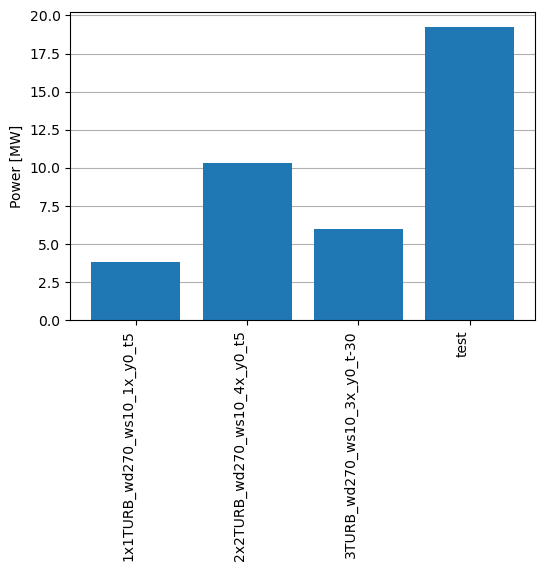

In [122]:
cases = list(case_manager.cases.values())

plot_total_power_comparison(cases)

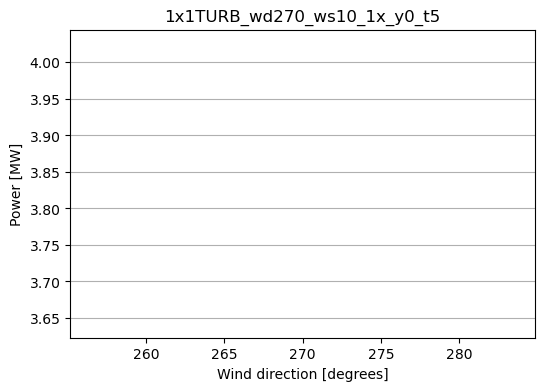

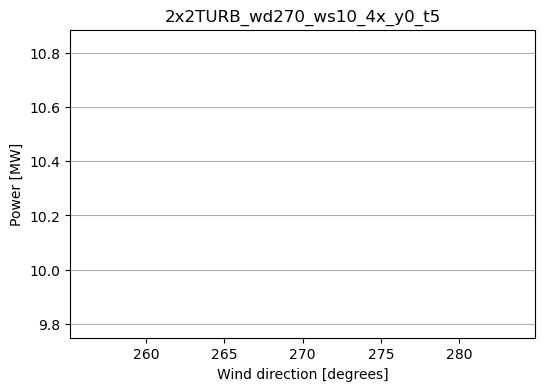

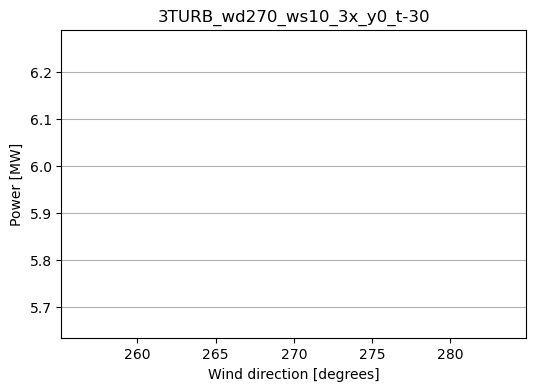

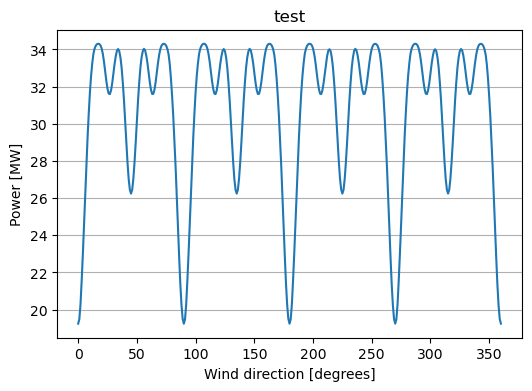

In [103]:
plot_powers_wd(cases)

### Visualize flowfield
Here, examples are shown of how plots can be made of flowfields. Several extra options are present in the function.

floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


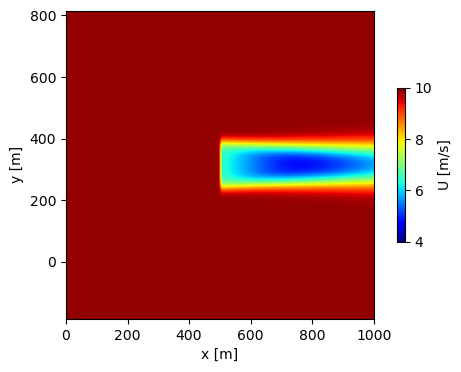

floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


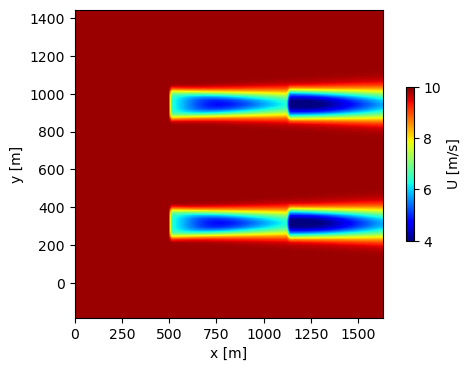

floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


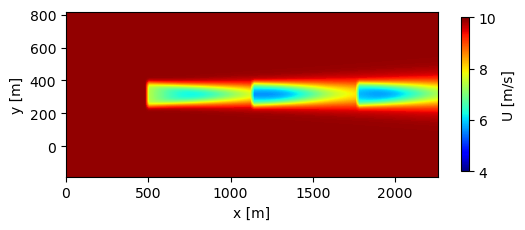

floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


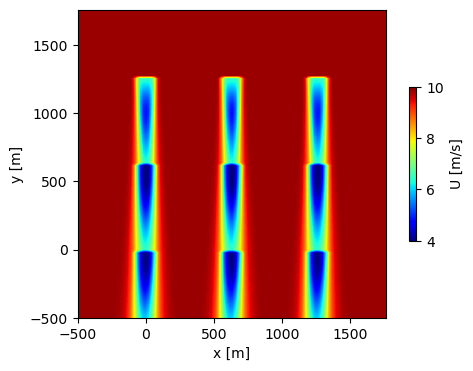

floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


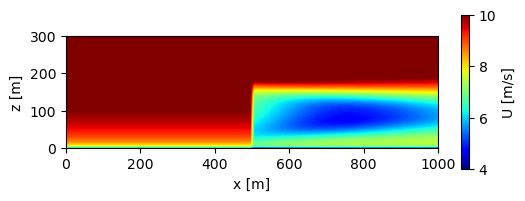

floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


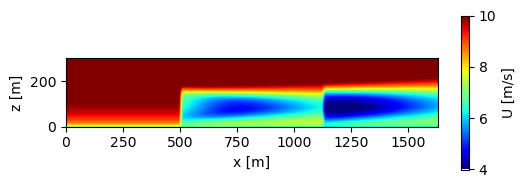

floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


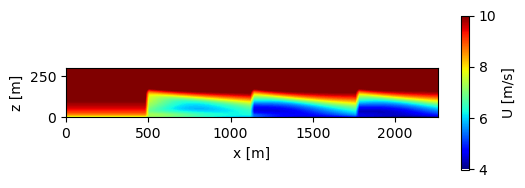

floris.tools.floris_interface.FlorisInterface WARNING The only unique hub-height is not the equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to  indicate use of hub-height as reference wind height.


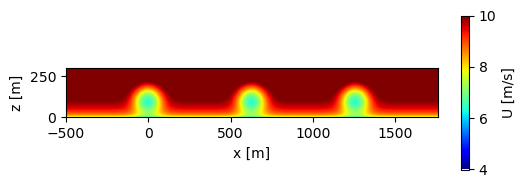

In [90]:
for case_name in case_manager.case_names:
    viz.plot_velocity_field(
        wakemodeling=wakemodeling,
        config=case_manager.cases[case_name].config,
        component='U',
        plane='Z',
        distance=90,
    )

for case_name in case_manager.case_names:
    viz.plot_velocity_field(
        wakemodeling=wakemodeling,
        config=case_manager.cases[case_name].config,
        component='U',
        plane='Y',
        distance=case_manager.cases[case_name].config['y_ij'][0,0],
    )